# Creating a custom Xarray index

## STILL TO DO
- `.align()`
- plug in diff transform (or leave for later)
- move text over from outline

This tutorial demonstrates creating a custom Xarray index object using `.set_xindex()`. We detail scenarios where non-standard index functionality is helpful and walk through the function and components of Xarray `Index` objects.

In [1]:
import xarray as xr 
import numpy as np
import pandas as pd
from collections.abc import Sequence


from xarray import Index
from xarray.core.indexes import PandasIndex
from xarray.core.indexing import merge_sel_results
import matplotlib.pyplot as plt

Create sample data. This will be a one-dimensional `xr.Dataset` with an index along the `'x'` dimension. We would like to query this dataset from a different coordinate reference system (eg. longitude). Information describing the relationship between the two coordinate reference systems will be stored in the attributes of a `spatial_ref` object.

In [2]:
da = xr.DataArray(
    data = np.random.rand(10),
    dims = ('x'),
    coords = {
        'x':np.arange(10),
        })
da.attrs['xkey'] = '2'
da.attrs['xvals'] = list(np.arange(10))
#da.x.attrs['xkey'] = '2'
#da.x.attrs['xvals'] = list(np.arange(10))
ds = xr.Dataset({'var1':da
                })

spatial_ref = xr.DataArray()
spatial_ref.attrs['factor'] = 2 #toy standin for transform aprams
spatial_ref.attrs['real_name'] = 'lon'
spatial_ref.attrs['idx_name'] = 'x'
ds['spatial_ref'] = spatial_ref
ds = ds.set_coords('spatial_ref')

ds = ds.expand_dims({'y':1})

In [3]:
kwargs = {'vmax':ds.var1.max(), 'vmin':ds.var1.min()}

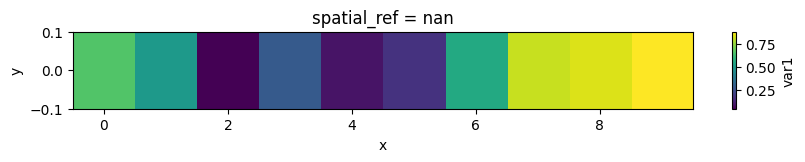

In [4]:
ds.var1.plot.imshow(figsize=(10,1), **kwargs, label='test');

## Define a custom index class

In [5]:
class ToyIndex_scalar(xr.Index): #customindex inherits xarray Index
    def __init__(self, x_indexes, variables):
        
        self.indexes = variables
        self._xindexes = x_indexes 
        self.spatial_ref = variables['spatial_ref']
    @classmethod          
    def from_variables(cls,variables, **kwargs):
        '''this method creates a ToyIndex obj from a variables object.
        variables created like this:
        coord_vars = {name:ds._variables[name] for name in coord_names}
        coord_names is passed to set_xindex
        '''
        assert len(variables) == 2
        assert 'x' in variables
        assert 'spatial_ref' in variables 
        
        dim_variables = {}
        scalar_vars = {}
        for k,i in variables.items():
            if variables[k].ndim ==1:
                dim_variables[k] = variables[k]
            if variables[k].ndim ==0:
                scalar_vars[k] = variables[k]
        
        options = {'dim':'x',
                   'name':'x'}
        
        x_indexes = {
            k: PandasIndex.from_variables({k: v}, options = options) 
            for k,v in dim_variables.items()
        }
        
        x_indexes['spatial_ref'] = variables['spatial_ref']
        #instance = cls(x_indexes, scalar_vars)
        #return instance
        #print('scalar vars ', scalar_vars)
        #return cls(x_indexes, scalar_vars)
        return cls(x_indexes, variables)
    
    def create_variables(self, variables):
        '''creates coord variable from index'''
       
        idx_variables = {}
      
        for index in self._xindexes.values():
            #want to skip spatial ref
            if type(index) == xr.core.variable.Variable:
                pass
            else:
                #only create variable for x
                x = index.create_variables(variables)
                idx_variables.update(x)
        idx_variables['spatial_ref'] = variables['spatial_ref']          
        return idx_variables

    def transform(self, value):
        
        #extract attrs
        fac = self.spatial_ref.attrs['factor']
        key = self.spatial_ref.attrs['idx_name']

        #handle slice
        if isinstance(value, slice):
            
            start, stop, step = value.start, value.stop, value.step
            new_start, new_stop, new_step = start / fac, stop/fac, step
            new_val = slice(new_start, new_stop, new_step)
            transformed_labels = {key: new_val}
            return transformed_labels
        
        #single or list of values
        else:
        
            vals_to_transform = [] 

            if not isinstance(value, Sequence):
                value = [value]

            for k in range(len(value)):

                val = value[k]
                vals_to_transform.append(val)

            #logic for parsing attrs, todo: switch to actual transform
            transformed_x = [int(v / fac) for v in vals_to_transform]

            transformed_labels = {key:transformed_x}
            return transformed_labels

    def sel(self, labels):
        
        assert type(labels) == dict
        
        label = next(iter(labels.values()))
        idx = self.transform(label)
        results = []
        for k, index in self._xindexes.items():
            
            if k in idx:
                                
                results.append(index.sel({k: idx[k]}))
                
        return merge_sel_results(results)
    
    def equals(self, other):
        
        result = self._indexes['x'].equals(other._indexes['x']) and self._indexes['spatial_ref'].equals(other._indexes['spatial_ref'])
        
        return result
 

In [6]:
ds.sel(x=4).var1.data

array([0.08425221])

In [7]:
ds = ds.drop_indexes('x')

In [8]:
ds_new = ds.set_xindex(['x','spatial_ref'],ToyIndex_scalar)

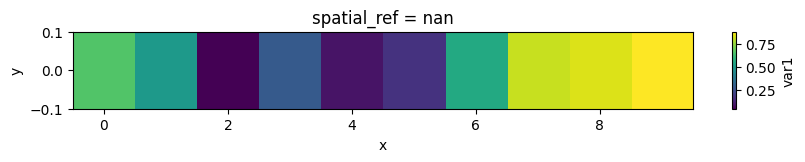

In [9]:
ds_new.var1.plot.imshow(figsize=(10,1), **kwargs);

### Custome index implementation of `.sel()` 

Single value:

In [ ]:
ds_new.sel(x=[8,12])

List of values:

In [34]:
ds_new.sel(x=[8,12])

<xarray.Dataset> Size: 40B
Dimensions:      (y: 1, x: 2)
Coordinates:
    x            (x) int64 16B 4 6
    spatial_ref  float64 8B nan
Dimensions without coordinates: y
Data variables:
    var1         (y, x) float64 16B 0.08425 0.5561

Slices:

In [11]:
ds_new_sub = ds_new.sel(x=slice(4,8))
#ds_new_sub = ds_new_sub.set_xindex('x',ToyIndex_scalar)
#question -- do we want a subset to have an index? I think so but woudl need to .set_xindex and this isn't quite the same as aboev

In [13]:
ds_new_sub

<xarray.Dataset> Size: 56B
Dimensions:      (y: 1, x: 3)
Coordinates:
    x            (x) int64 24B 2 3 4
    spatial_ref  float64 8B nan
Dimensions without coordinates: y
Data variables:
    var1         (y, x) float64 24B 0.04055 0.2793 0.08425

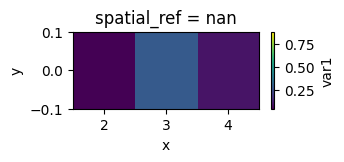

In [14]:
ds_new_sub.var1.plot.imshow(figsize=(3,1), **kwargs);


Drop these from original:

In [15]:
x_to_drop = np.arange(2,5)

In [16]:
x_to_drop

array([2, 3, 4])

In [20]:
ds

<xarray.Dataset> Size: 168B
Dimensions:      (x: 10, y: 1)
Coordinates:
    x            (x) int64 80B 0 1 2 3 4 5 6 7 8 9
    spatial_ref  float64 8B nan
Dimensions without coordinates: y
Data variables:
    var1         (y, x) float64 80B 0.6589 0.4974 0.04055 ... 0.8423 0.8882

In [22]:
ds = ds.reindex({'x':ds.x})

In [23]:
ds_sub = ds.drop_sel(x=x_to_drop)


In [24]:
ds_sub

<xarray.Dataset> Size: 120B
Dimensions:      (x: 7, y: 1)
Coordinates:
  * x            (x) int64 56B 0 1 5 6 7 8 9
    spatial_ref  float64 8B nan
Dimensions without coordinates: y
Data variables:
    var1         (y, x) float64 56B 0.6589 0.4974 0.1661 ... 0.8423 0.8882

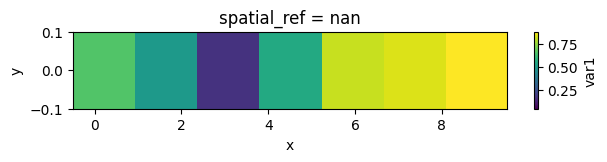

In [26]:
ds_sub.var1.plot.imshow(figsize=(7,1),**kwargs);


In [28]:
#da1, da2 = xr.align(ds_sub, ds_new_sub, join='outer')

In [29]:
ds_new_sub

<xarray.Dataset> Size: 56B
Dimensions:      (y: 1, x: 3)
Coordinates:
    x            (x) int64 24B 2 3 4
    spatial_ref  float64 8B nan
Dimensions without coordinates: y
Data variables:
    var1         (y, x) float64 24B 0.04055 0.2793 0.08425

In [30]:
ds_new._indexes['spatial_ref']

In [33]:
ds

<xarray.Dataset> Size: 168B
Dimensions:      (x: 10, y: 1)
Coordinates:
  * x            (x) int64 80B 0 1 2 3 4 5 6 7 8 9
    spatial_ref  float64 8B nan
Dimensions without coordinates: y
Data variables:
    var1         (y, x) float64 80B 0.6589 0.4974 0.04055 ... 0.8423 0.8882

Alignment

For an index to support alignment, it needs to implement:

    Index.equals(), which compares the index with another index and returns either True or False

    Index.join(), which combines the index with another index and returns a new Index object

    Index.reindex_like(), which queries the index with another index and returns positional indexers that are used to re-index Dataset or DataArray variables along one or more dimensions

Xarray ensures that those three methods are called with an index of the same type as argument.